## Import All Libraries

In [13]:
import os
import numpy as np 
import pandas as pd 
from skimage.io import imread
import matplotlib.pyplot as plt
from itertools import chain
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense 
import keras 
from skmultilearn.model_selection import iterative_train_test_split


### Defining base model and neccessary labels

In [2]:
Base_Model= 'VGG16'
IMG_SIZE= (224,224)
train_image_dir = os.path.join('train')
test_image_dir = os.path.join('test')
import gc; gc.enable() # memory is tight
name_label_dict = {
    0:  "Nucleoplasm", 
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center" ,  
    4:  "Nuclear speckles"   ,
    5:  "Nuclear bodies"   ,
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus"   ,
    8:  "Peroxisomes"   ,
    9:  "Endosomes"   ,
    10:  "Lysosomes"   ,
    11:  "Intermediate filaments",   
    12:  "Actin filaments"   ,
    13:  "Focal adhesion sites",   
    14:  "Microtubules"   ,
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle"   ,
    18:  "Microtubule organizing center" ,  
    19:  "Centrosome"   ,
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions"  , 
    23:  "Mitochondria"   ,
    24:  "Aggresome"   ,
    25:  "Cytosol",
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings" 
    }

In [3]:
# number of validation images to use
VALID_IMG_COUNT = 1500
Valid_train_count= 11000
# number of images per category to keep 
TRAIN_IMAGES_PER_CATEGORY = 500 
EPOCHS = 10
RGB_FLIP = 1 # should rgb be flipped when rendering images

Merging csv files with proper labels to the images

In [4]:
image_df = pd.read_csv(os.path.join('train.csv'))
print(image_df.shape[0], 'masks found')
print(image_df['Id'].value_counts().shape[0])
# just use green for now
image_df['path'] = image_df['Id'].map(lambda x: os.path.join(train_image_dir, '{}.rgb'.format(x)))
image_df['target_list'] = image_df['Target'].map(lambda x: [int(a) for a in x.split(' ')])
image_df.head()

31072 masks found
31072


,Id,Target,path,target_list
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0.rgb,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0.rgb,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0.rgb,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,train/000c99ba-bba4-11e8-b2b9-ac1f6b6435d0.rgb,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,train/001838f8-bbca-11e8-b2bc-ac1f6b6435d0.rgb,[18]


### EDA

Cytokinetic bridge count: 530
Nucleoplasm count: 12885
Golgi apparatus count: 2822
Nuclear membrane count: 1254
Nucleoli count: 3621
Nuclear bodies count: 2513
Microtubule organizing center count: 902
Cytosol count: 8228
Mitochondria count: 2965
Plasma membrane count: 3777
Aggresome count: 322
Endoplasmic reticulum count: 1008
Intermediate filaments count: 1093
Nucleoli fibrillar center count: 1561
Actin filaments count: 688
Focal adhesion sites count: 537
Microtubules count: 1066
Nuclear speckles count: 1858
Lipid droplets count: 172
Cell junctions count: 802
Mitotic spindle count: 210
Centrosome count: 1482
Peroxisomes count: 53
Endosomes count: 45
Lysosomes count: 28
Cytoplasmic bodies count: 328
Rods & rings count: 11
Microtubule ends count: 21


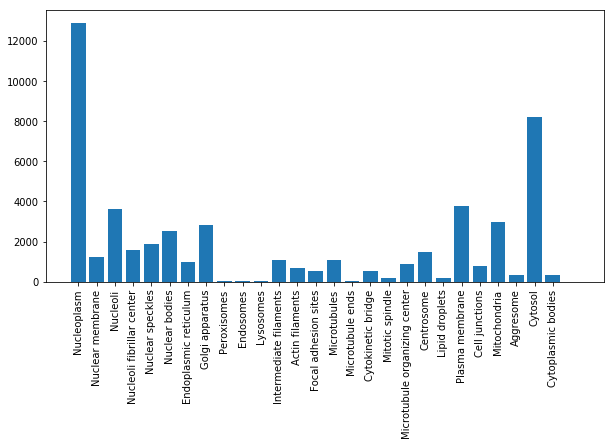

In [5]:
all_labels = list(chain.from_iterable(image_df['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
fig, ax1 = plt.subplots(1,1, figsize = (10, 5))
ax1.bar(n_keys, [c_val[k] for k in n_keys])
ax1.set_xticks(range(max_idx))
ax1.set_xticklabels([name_label_dict[k] for k in range(max_idx)], rotation=90)
for k,v in c_val.items():
    print(name_label_dict[k], 'count:', v)

In [6]:
name= list(name_label_dict.values())
name

['Nucleoplasm',
 'Nuclear membrane',
 'Nucleoli',
 'Nucleoli fibrillar center',
 'Nuclear speckles',
 'Nuclear bodies',
 'Endoplasmic reticulum',
 'Golgi apparatus',
 'Peroxisomes',
 'Endosomes',
 'Lysosomes',
 'Intermediate filaments',
 'Actin filaments',
 'Focal adhesion sites',
 'Microtubules',
 'Microtubule ends',
 'Cytokinetic bridge',
 'Mitotic spindle',
 'Microtubule organizing center',
 'Centrosome',
 'Lipid droplets',
 'Plasma membrane',
 'Cell junctions',
 'Mitochondria',
 'Aggresome',
 'Cytosol',
 'Cytoplasmic bodies',
 'Rods & rings']

In [7]:
c_val.items()

dict_items([(16, 530), (0, 12885), (7, 2822), (1, 1254), (2, 3621), (5, 2513), (18, 902), (25, 8228), (23, 2965), (21, 3777), (24, 322), (6, 1008), (11, 1093), (3, 1561), (12, 688), (13, 537), (14, 1066), (4, 1858), (20, 172), (22, 802), (17, 210), (19, 1482), (8, 53), (9, 45), (10, 28), (26, 328), (27, 11), (15, 21)])

In [8]:
# create a categorical vector
image_df['target_vec'] = image_df['target_list'].map(lambda ck: [i in ck for i in range(max_idx+1)])
image_df.head()

,Id,Target,path,target_list,target_vec
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0.rgb,"[16, 0]","[True, False, False, False, False, False, Fals..."
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0.rgb,"[7, 1, 2, 0]","[True, True, True, False, False, False, False,..."
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0.rgb,[5],"[False, False, False, False, False, True, Fals..."
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,train/000c99ba-bba4-11e8-b2b9-ac1f6b6435d0.rgb,[1],"[False, True, False, False, False, False, Fals..."
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,train/001838f8-bbca-11e8-b2bc-ac1f6b6435d0.rgb,[18],"[False, False, False, False, False, False, Fal..."


In [24]:
#non working multi strat
# y=(image_df['Target'].map(lambda x: x[:3] if '27' not in x else '0')
# raw_train_df, valid_df = iterative_train_test_split((image_df,y,test_size=0.35)))
#working single strat
raw_train_df, valid_df = train_test_split(image_df, 
                 test_size = 0.35, 
                  # hack to make stratification work  
                 stratify = image_df['Target'].map(lambda x: x[:3] if '27' not in x else '0'))
print(raw_train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

20196 training masks
10876 validation masks


Dropping any training sets with less than 200 datasets

In [25]:
# keep labels with more then 200 and less than 4000 objects
out_df_list = []
for k,v in c_val.items():
    if v>=25:
        keep_rows = raw_train_df['target_list'].map(lambda x: k in x)
        out_df_list += [raw_train_df[keep_rows].sample(TRAIN_IMAGES_PER_CATEGORY, 
                                                       replace=True)]
train_df = pd.concat(out_df_list, ignore_index=True)
print(train_df.shape[0])
train_df.head()

13000


,Id,Target,path,target_list,target_vec
0,1e5fcdaa-bbaf-11e8-b2ba-ac1f6b6435d0,16,train/1e5fcdaa-bbaf-11e8-b2ba-ac1f6b6435d0.rgb,[16],"[False, False, False, False, False, False, Fal..."
1,34af637a-bbca-11e8-b2bc-ac1f6b6435d0,16 14,train/34af637a-bbca-11e8-b2bc-ac1f6b6435d0.rgb,"[16, 14]","[False, False, False, False, False, False, Fal..."
2,c1792652-bba1-11e8-b2b9-ac1f6b6435d0,19 7 16,train/c1792652-bba1-11e8-b2b9-ac1f6b6435d0.rgb,"[19, 7, 16]","[False, False, False, False, False, False, Fal..."
3,8ecf93ae-bbb9-11e8-b2ba-ac1f6b6435d0,16 14,train/8ecf93ae-bbb9-11e8-b2ba-ac1f6b6435d0.rgb,"[16, 14]","[False, False, False, False, False, False, Fal..."
4,5b22d790-bbb0-11e8-b2ba-ac1f6b6435d0,16 0,train/5b22d790-bbb0-11e8-b2ba-ac1f6b6435d0.rgb,"[16, 0]","[True, False, False, False, False, False, Fals..."


Text(0.5, 1.0, 'Validation Distribution')

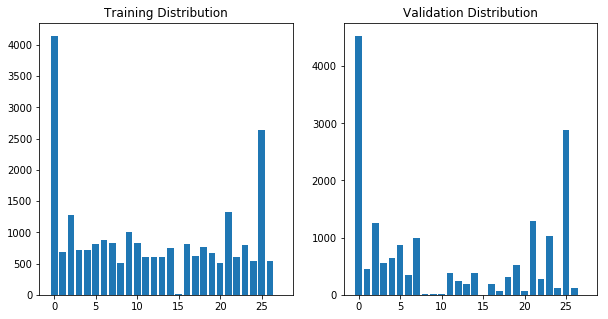

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
train_sum_vec = np.sum(np.stack(train_df['target_vec'].values, 0), 0)
valid_sum_vec = np.sum(np.stack(valid_df['target_vec'].values, 0), 0)
ax1.bar(n_keys, [train_sum_vec[k] for k in n_keys])
ax1.set_title('Training Distribution')
ax2.bar(n_keys, [valid_sum_vec[k] for k in n_keys])
ax2.set_title('Validation Distribution')

Building of Base Model

In [13]:
if Base_Model=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [14]:
try:
    # keras 2.2
    import keras_preprocessing.image as KPImage
except:
    # keras 2.1
    import keras.preprocessing.image as KPImage
    
from PIL import Image
class rgb_pil():
    @staticmethod
    def open(in_path):
        if '.rgb' in in_path:
            r_img = np.array(Image.open(in_path.replace('.rgb', '_red.png'))).astype(np.float32)
            g_img = np.array(Image.open(in_path.replace('.rgb', '_green.png'))).astype(np.float32)
            y_img = np.array(Image.open(in_path.replace('.rgb', '_yellow.png'))).astype(np.float32)
            b_img = Image.open(in_path.replace('.rgb', '_blue.png'))
            
            rgb_arr = np.stack([r_img/2+y_img/2, g_img/2+y_img/2, b_img], -1).clip(0, 255).astype(np.uint8)
            return Image.fromarray(rgb_arr)
        else:
            return Image.open(in_path)
    fromarray = Image.fromarray
KPImage.pil_image = rgb_pil

In [15]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  height_shift_range = 0.1, 
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                   data_format = 'channels_last',
              preprocessing_function = preprocess_input)

valid_args = dict(fill_mode = 'reflect',
                   data_format = 'channels_last',
                  preprocessing_function = preprocess_input)

core_idg = ImageDataGenerator(**dg_args)
valid_idg = ImageDataGenerator(**valid_args)

Only run the cell below once

from IPython.display import clear_output
train_gen.batch_size = BATCH_SIZE
fit_results = protein_model.fit_generator(train_gen, 
                            steps_per_epoch = train_gen.samples//BATCH_SIZE,
                      validation_data = (valid_x, valid_y), 
                      epochs = EPOCHS, 
                      callbacks = callbacks_list,
                      workers = 3)

In [16]:
weight_path="{}_weights.best.hdf5".format('boat_detector')

Setting up a function for flow_directory

In [17]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

Iteration of flow dataframe

In [18]:
tx, ty = next(flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'target_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = Valid_train_count))

# used a fixed dataset for evaluating the algorithm
valid_x, valid_y = next(flow_from_dataframe(valid_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'target_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = VALID_IMG_COUNT)) # one big batch
print(valid_x.shape, valid_y.shape)
print(tx.shape, ty.shape)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 11000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10876 images
(1500, 224, 224, 3) (1500, 28)
(11000, 224, 224, 3) (11000, 28)


## Making the Best Model

In [22]:
model = Sequential()  
model.add(Flatten(input_shape=tx.shape[1:]))  
model.add(Dense(1000, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.3))
model.add(Dense(500, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.2))
model.add(Dense(ty.shape[1], activation='sigmoid'))  

model.compile(optimizer='adam',  
          loss='binary_crossentropy', metrics=['binary_accuracy'])  
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              150529000 
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 750)               750750    
_________________________________________________________________
dropout_5 (Dropout)          (None, 750)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               375500    
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)              

Fitting the model to data set

In [35]:
history = model.fit(tx, ty,  
      epochs=15,  
      batch_size=500,  
      validation_data=(valid_x, valid_y))  

model.save_weights(weight_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 valid_x, valid_y, batch_size=100, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))

Train on 11000 samples, validate on 1500 samples
Epoch 1/15
11000/11000 [==============================] - 131s 12ms/step - loss: 1.5058 - binary_accuracy: 0.9062 - val_loss: 1.1966 - val_binary_accuracy: 0.9255
Epoch 2/15
11000/11000 [==============================] - 132s 12ms/step - loss: 1.5006 - binary_accuracy: 0.9065 - val_loss: 1.1966 - val_binary_accuracy: 0.9255
Epoch 3/15
11000/11000 [==============================] - 125s 11ms/step - loss: 1.4999 - binary_accuracy: 0.9066 - val_loss: 1.1966 - val_binary_accuracy: 0.9255
Epoch 4/15
11000/11000 [==============================] - 130s 12ms/step - loss: 1.5019 - binary_accuracy: 0.9064 - val_loss: 1.1966 - val_binary_accuracy: 0.9255
Epoch 5/15
11000/11000 [==============================] - 126s 11ms/step - loss: 1.4998 - binary_accuracy: 0.9066 - val_loss: 1.1966 - val_binary_accuracy: 0.9255
Epoch 6/15
11000/11000 [==============================] - 125s 11ms/step - loss: 1.4984 - binary_accuracy: 0.9067 - val_loss: 1.1966 - v

Accuracy and Loss Graph

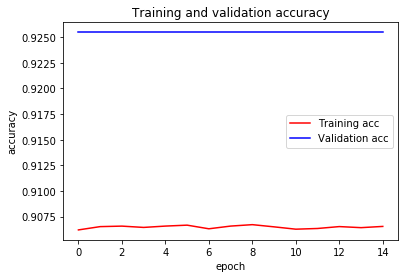

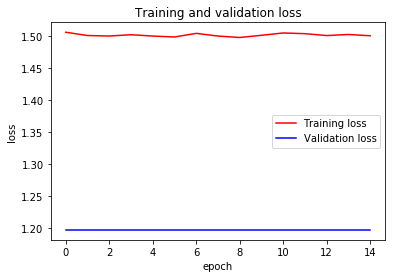

In [37]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

## Testing set

In [38]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')
submission_df = pd.read_csv('sample_submission.csv')
submission_df['path'] = submission_df['Id'].map(lambda x: os.path.join(test_image_dir, '{}.rgb'.format(x)))
submission_df.head()

46808 test images found


,Id,Predicted,path
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0,test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0.rgb
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0,test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0.rgb
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0,test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0.rgb
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0,test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0.rgb
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0,test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0.rgb


In [39]:
test_set = flow_from_dataframe(valid_idg, 
                               submission_df, 
                             path_col = 'path',
                            y_col = 'Predicted', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 64, 
                              shuffle = False)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 11702 images


### Let's test it out

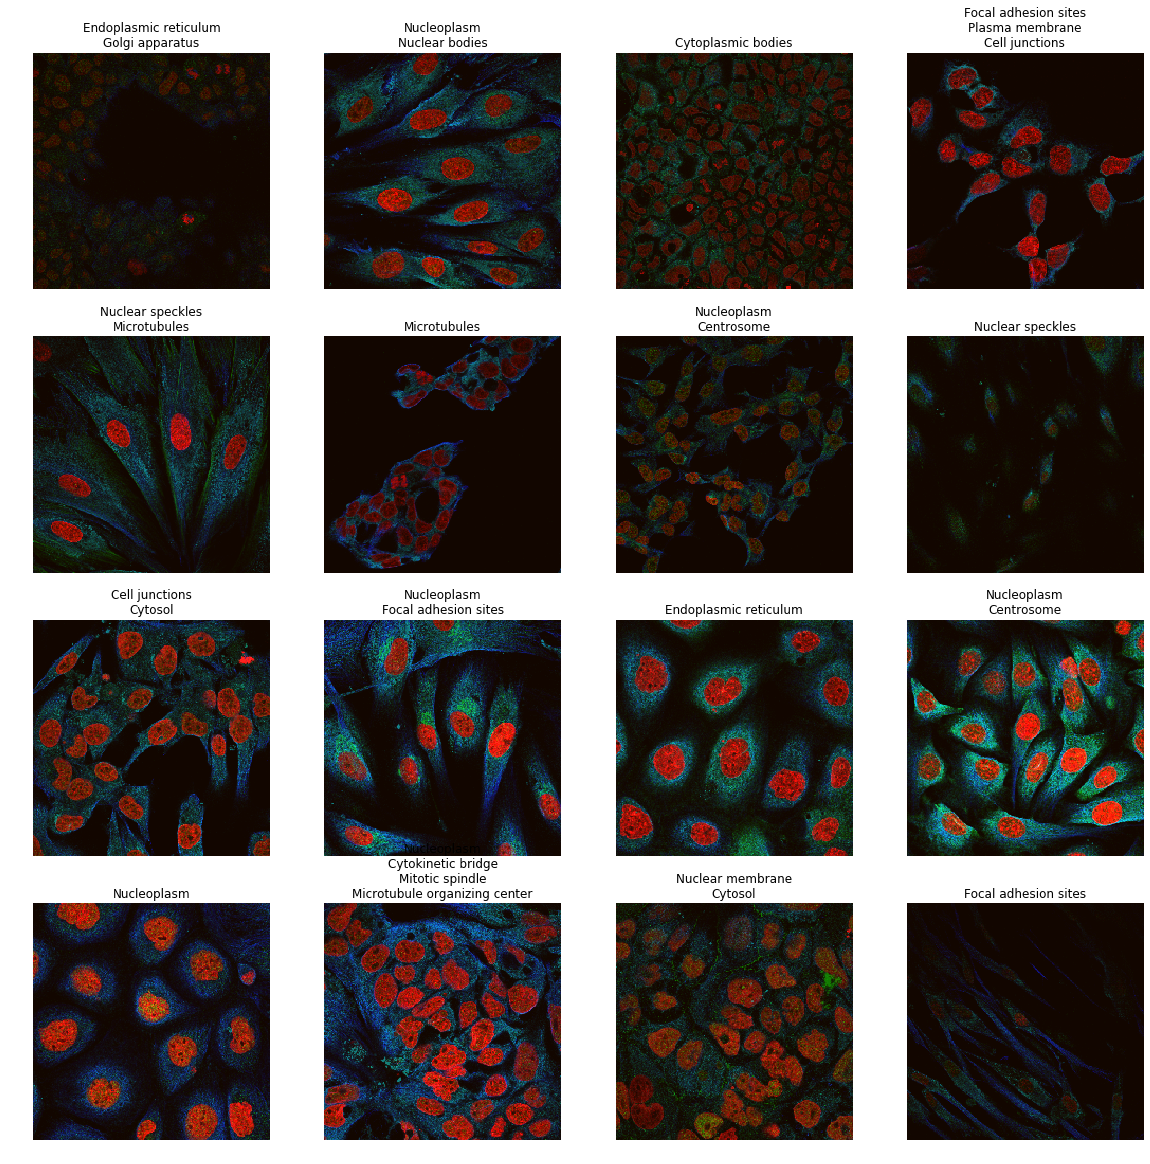

In [55]:
test_x, test_y = next(test_set)
fig, (m_axs) = plt.subplots(4, 4, figsize = (20, 20))
for i, c_ax in enumerate(m_axs.flatten()):
    c_ax.imshow(((test_x[i]-test_x.min())/(test_x.max()-test_x.min()))[:, ::RGB_FLIP])
    c_title = '\n'.join(['{}'.format(name_label_dict[j], v)
                         for j, v in enumerate(ty[i]) if v>0.25])
    c_ax.set_title(c_title)
    c_ax.axis('off')

## Conclusion

This dataset is very different than my original dataset. It was a bit more difficult to work with. Nevertheless, this dataset had a high resolution pictures so my algorithm was able to properly identify cell organelles with a 94% accuracy.